*   Prachi Patel
*   Machine Learning
*   Final Project

# Gated Recurrent Unit (GRU) to Predict the closing stock price of a corporation

Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import GRU,Dropout,Dense
from keras.optimizers import SGD

# Building the regression model
from sklearn.model_selection import train_test_split

# For Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import plotly.graph_objs as go
from plotly.offline import plot

#for offline plotting
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

Load data

In [ ]:
data=pd.read_csv("ibm.us.txt")
# data_prev, data = train_test_split(data, test_size=0.23, shuffle=False)
data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1962-01-02,6.4130,6.4130,6.3378,6.3378,467056,0
1,1962-01-03,6.3378,6.3963,6.3378,6.3963,350294,0
2,1962-01-04,6.3963,6.3963,6.3295,6.3295,314365,0
3,1962-01-05,6.3211,6.3211,6.1958,6.2041,440112,0
4,1962-01-08,6.2041,6.2041,6.0373,6.0870,655676,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14059 entries, 0 to 14058
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     14059 non-null  object 
 1   Open     14059 non-null  float64
 2   High     14059 non-null  float64
 3   Low      14059 non-null  float64
 4   Close    14059 non-null  float64
 5   Volume   14059 non-null  int64  
 6   OpenInt  14059 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 769.0+ KB


In [ ]:
# Setting the layout for plot
layout = go.Layout(
    title = 'Stock Prices for IBM',
    xaxis = dict(
        title = 'Date',
        titlefont = dict(
            family = 'Courier New, monospace',
            size = 20,
            color = '#7f7f7f'
        )
    ),
    yaxis = dict(
        title = 'Price',
        titlefont = dict(
            family = 'Courier New, monospace',
            size = 20,
            color = '#7f7f7f'
        )
    )
)

Plot data on graph

In [ ]:
data['Date']=pd.to_datetime(data.Date,format="%Y-%m-%d")
data.index=data['Date']
# data
stock_data = [{'x': data['Date'], 'y': data['Close']}]
plot = go.Figure(data=stock_data, layout = layout)
plot.show(renderer="colab")
iplot(plot)

In [ ]:
df_data=data.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(data)),columns=['Date','Close'])
for i in range(0,len(df_data)):
    new_dataset["Date"][i]=df_data['Date'][i]
    new_dataset["Close"][i]=df_data["Close"][i]

In [ ]:
new_dataset.shape

(14059, 2)

Split data into Train and Test dataset

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
final_dataset=new_dataset.values

train_data=final_dataset[0:13694,:]
valid_data=final_dataset[13694:,:]

new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)
scaled_data=scaler.fit_transform(new_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

Implement GRU model

In [ ]:
# The GRU architecture
regressorGRU = Sequential()
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train_data.shape[1],1), activation='tanh'))
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train_data.shape[1],1), activation='tanh'))
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train_data.shape[1],1), activation='tanh'))
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dense(units=1))

In [ ]:
 # Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')

In [ ]:
# Fitting to the training set
regressorGRU.fit(x_train_data,y_train_data,epochs=1,batch_size=150)

91/91 [==============================] - 28s 232ms/step - loss: 0.0509


In [ ]:
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

In [ ]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=regressorGRU.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

Plot Predicted closing price of the stock

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



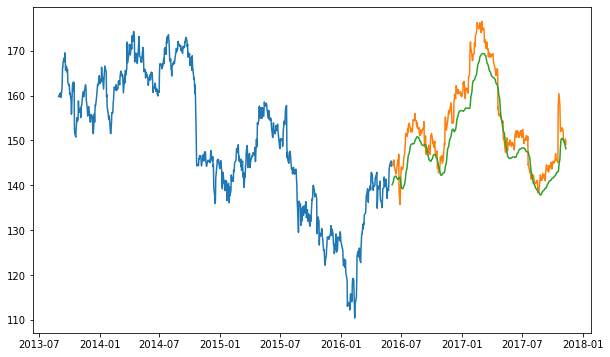

In [ ]:
train_data=new_dataset[13000:13694]
valid_data=new_dataset[13694:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])
# plt.rcParams["figure.figsize"] = (10,6)
# x1,x2,y1,y2 = plt.axis()  
# plt.axis((x1,x2,y1,190))